In [37]:
%reload_ext autoreload
%autoreload 2
import ast
import pickle
import itertools
from collections import Counter
from tqdm import tqdm
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import swifter

import sys
sys.path.append('..')
from analysis.generate_cluster_information_file import load, extract_all_information_query, to_df_query
from common.image_processing import pixel_intensity_histogram


from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.linear_model import Lasso

In [124]:
train_X = pd.read_csv('train_X.csv', dtype='float')
train_y = pd.read_csv('train_y.csv', dtype='float')

test_X = pd.read_csv('test_X.csv', dtype='float')

assert train_X.shape[1] == test_X.shape[1]

na_indices = train_X[train_X.isna().any(axis=1)].index.values
train_X.drop(na_indices, inplace=True)
train_y.drop(na_indices, inplace=True)

print(train_X.shape)
print(train_X.columns.values)
train_X.head(10)

(9600, 26)
['cluster_num' 'background_threshold' 'cluster_num_intensities_avg'
 'cluster_num_intensities_max' 'cluster_num_intensities_min'
 'cluster_num_intensities_std' 'cluster_peak_intensities_avg'
 'cluster_peak_intensities_max' 'cluster_peak_intensities_min'
 'cluster_peak_intensities_std' 'cluster_sizes_avg' 'cluster_sizes_std'
 'cluster_sizes_max' 'cluster_sizes_min' 'cluster_sizes_sum'
 'cluster_x_avg' 'cluster_y_avg' 'cluster_dist_min' 'cluster_dist_max'
 'largest_clusters_distance' 'brightest_clusters_distance'
 'num_large_clusters' 'num_small_clusters' 'num_bright_clusters'
 'num_dark_clusters' 'num_large_bright_clusters']


,cluster_num,background_threshold,cluster_num_intensities_avg,cluster_num_intensities_max,cluster_num_intensities_min,cluster_num_intensities_std,cluster_peak_intensities_avg,cluster_peak_intensities_max,cluster_peak_intensities_min,cluster_peak_intensities_std,...,cluster_y_avg,cluster_dist_min,cluster_dist_max,largest_clusters_distance,brightest_clusters_distance,num_large_clusters,num_small_clusters,num_bright_clusters,num_dark_clusters,num_large_bright_clusters
0,50.0,0.0,6.680000,71.0,1.0,13.844046,14.920000,255.0,1.0,49.370777,...,475.320000,19.235384,1251.265360,418.150691,418.150691,42.0,8.0,17.0,33.0,17.0
1,104.0,0.0,5.692308,61.0,1.0,11.164915,11.375000,255.0,1.0,36.751030,...,473.798077,17.204651,1223.943218,537.729486,605.561723,84.0,20.0,27.0,77.0,27.0
2,71.0,1.0,5.605634,84.0,1.0,12.496173,11.563380,255.0,2.0,34.161890,...,513.746479,24.041631,1235.969255,758.641549,841.503417,59.0,12.0,24.0,47.0,24.0
3,49.0,2.0,8.428571,69.0,1.0,13.074356,22.612245,255.0,3.0,51.612297,...,564.571429,13.601471,1243.556995,798.068919,257.670332,43.0,6.0,33.0,16.0,33.0
4,169.0,0.0,3.284024,47.0,1.0,6.639654,6.621302,255.0,1.0,26.394791,...,509.230769,2.000000,1319.351735,1064.421439,137.116739,115.0,54.0,28.0,141.0,28.0
5,51.0,1.0,10.450980,80.0,1.0,17.443819,26.921569,255.0,2.0,64.565772,...,492.352941,21.954498,1135.750853,344.653449,337.831319,45.0,6.0,25.0,26.0,25.0
6,2216.0,191.0,3.131318,63.0,1.0,4.407226,196.498195,254.0,192.0,6.801996,...,468.828520,2.000000,1187.283454,646.561675,366.006831,622.0,1594.0,2216.0,0.0,622.0
7,66.0,0.0,6.409091,70.0,1.0,13.259619,15.045455,255.0,1.0,46.085044,...,427.469697,8.062258,1153.087161,267.029961,267.029961,49.0,17.0,20.0,46.0,20.0
8,73732.0,9.0,2.120314,42.0,1.0,1.713660,17.661884,255.0,10.0,5.843887,...,497.128208,8.062258,1153.087161,1.000000,1.000000,9143.0,64589.0,73732.0,0.0,9143.0
9,35.0,1.0,6.257143,80.0,1.0,14.468375,14.171429,255.0,2.0,44.876011,...,514.942857,14.317821,1216.550040,444.668416,444.668416,29.0,6.0,15.0,20.0,15.0


In [75]:
test_X

,cluster_num,background_threshold,cluster_num_intensities_avg,cluster_num_intensities_max,cluster_num_intensities_min,cluster_num_intensities_std,cluster_peak_intensities_avg,cluster_peak_intensities_max,cluster_peak_intensities_min,cluster_peak_intensities_std,...,cluster_x_avg,cluster_y_avg,cluster_dist_min,cluster_dist_max,largest_clusters_distance,brightest_clusters_distance,num_large_clusters,num_small_clusters,num_bright_clusters,num_dark_clusters
0,94.0,0.0,10.195514,6.055183e-312,1.052062e-153,6.042345e-312,12.585106,255.0,1.0,35.463619,...,478.127660,492.574468,5.385165,1243.907151,835.858840,463.967671,76.0,18.0,29.0,65.0
1,20943.0,187.0,7.855908,6.039858e-312,5.641140e-38,6.038737e-312,231.421334,255.0,188.0,20.871803,...,495.604498,527.738433,5.385165,1243.907151,1.000000,1.000000,8121.0,12822.0,20943.0,0.0
2,64.0,0.0,13.827304,6.055183e-312,2.999389e-67,6.055088e-312,18.312500,255.0,1.0,53.691211,...,574.046875,520.796875,12.369317,1260.242834,242.621104,242.621104,51.0,13.0,25.0,39.0
3,50.0,3.0,18.127780,6.053899e-312,9.456979e-96,6.040299e-312,27.860000,255.0,4.0,59.380808,...,465.060000,548.680000,20.518285,1256.561180,585.055553,793.015763,47.0,3.0,50.0,0.0
4,57.0,2.0,15.793995,6.055183e-312,2.887587e-57,6.034795e-312,16.631579,255.0,3.0,48.798056,...,478.228070,516.789474,16.124515,1277.351165,858.028554,858.028554,47.0,10.0,27.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,65.0,1.0,14.201958,6.055260e-312,1.052208e-153,6.042348e-312,18.876923,255.0,2.0,46.525264,...,541.123077,475.338462,23.259407,1149.921736,1066.404239,726.395209,49.0,16.0,23.0,42.0
1196,210.0,248.0,2.128630,6.041470e-312,1.245007e-47,6.039702e-312,251.309524,255.0,249.0,2.256083,...,284.019048,292.585714,2.000000,1131.209972,468.564830,509.574332,95.0,115.0,210.0,0.0
1197,80.0,0.0,12.230693,6.055260e-312,2.999397e-67,6.039955e-312,14.050000,255.0,1.0,43.180985,...,417.587500,523.887500,17.262677,1293.592285,781.768508,296.649625,68.0,12.0,24.0,56.0
1198,66.0,1.0,15.089852,6.055260e-312,1.039149e-95,6.059115e-312,22.060606,255.0,2.0,57.324139,...,464.969697,518.181818,9.055385,1260.174591,556.428791,556.428791,56.0,10.0,32.0,34.0


In [137]:
def train_with_features(X, y, features, drop=None, model='xgb', prepare_submission=False):    
    if drop is not None:
        test_X_ = test_X.drop(columns=drop)
        X = X.drop(columns=drop)
    elif type(features) == str and features == 'all':
        test_X_ = test_X
    else:
        X = X[features]
        test_X_ = test_X[features]
        
    print("Test: ", test_X_.shape)
    print("Train: ", X.shape)

    scaler = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    if model == 'rf':
        print("Model: Random Forest")
        model = RandomForestRegressor(max_depth=6, random_state=0)        
    elif model == 'svm':
        print("Model: SVM")
        model = SVR(kernel='rbf')
    elif model == 'xgb':
        print("Model: XGBoost")
        model = xgboost.XGBRegressor(objective="reg:squarederror", learning_rate =0.01, booster='gbtree', n_estimators=1000, max_depth=6, gamma=0.5, subsample=0.7, colsample_bytree=1.0, nthread=-1, verbosity=1)
    
    print("Cross validation...")
    score_mi = cross_val_score(model, X_scaled, np.ravel(y_scaled), cv=5, scoring=make_scorer(mean_absolute_error))
    print("Mean: {}, Std Dev: {}".format(score_mi.mean(), np.std(score_mi)))
    
    if prepare_submission:
        print("Fitting on whole dataset...")
        model.fit(X_scaled, np.ravel(y_scaled))
        print("Training predictions", scaler_y.inverse_transform(model.predict(X_scaled)))
        
        print("Preparing submission...")
        test_X_scaled = scaler.transform(test_X_)
        predictions = model.predict(test_X_scaled)
        predictions = scaler_y.inverse_transform(predictions)
        predictions = np.clip(predictions, 0, 8)
        
        print("Testing predictions: ", predictions)
        
        predictions_file_ids = [x.replace('.png', '') for x in os.listdir(os.path.join('..', 'data','query'))]
        results = {'Id': predictions_file_ids, 'Predicted': predictions.reshape(-1)}
        results = pd.DataFrame(data=results, dtype='float')
        results.Id = results.Id.astype('int')
        results.set_index('Id', inplace=True)
    
        results.to_csv('out.csv', index=True)

In [127]:
train_with_features(train_X, train_y, features=['cluster_num'], prepare_submission=False)

(1200, 1)
(9600, 1)
Model: XGBoost
Cross validation...
Mean: 0.6542359255209041, Std Dev: 0.010928812885586957


### Train with all features

In [129]:
train_with_features(train_X, train_y, 'all', 
                    drop=['cluster_num_intensities_max'],
                    model='xgb', prepare_submission=True)

Test:  (1200, 25)
Train:  (9600, 25)
Model: XGBoost
Cross validation...
Mean: 0.40711275944144776, Std Dev: 0.005006522019607747
Fitting on whole dataset...
Training predictions [2.760758   1.7369776  2.9552555  ... 1.7409087  2.5776567  0.00872598]
Preparing submission...
Testing predictions:  [1.4221292 0.        3.0503843 ... 2.343733  1.8989278 0.       ]


In [133]:
train_with_features(train_X, train_y, 'all', 
                    drop=None,
                    model='xgb', prepare_submission=False)

Test:  (1200, 26)
Train:  (9600, 26)
Model: XGBoost
Cross validation...
Mean: 0.3449159262873511, Std Dev: 0.011254787777934493


### Train with selected features
We select features according to the analysis (variance and mutual information) in feature_selection.ipynb

In [136]:
train_with_features(train_X, train_y, 'all', 
                    drop=['largest_clusters_distance', 'brightest_clusters_distance', 'cluster_dist_max', 'cluster_dist_min', 'cluster_sizes_min', 'cluster_num_intensities_min'],
                    model='xgb')

Test:  (1200, 20)
Train:  (9600, 20)
Model: XGBoost
Cross validation...
Mean: 0.34181271671565366, Std Dev: 0.011004444844366289


### LASSO
feature selection

In [97]:
lasso_features = ['brightest_clusters_distance', 'largest_clusters_distance', 'cluster_dist_min', 'cluster_sizes_min', 'background_threshold', 'cluster_peak_intensities_std', 'cluster_peak_intensities_min', 'cluster_peak_intensities_max']
train_with_features(train_X, lasso_features, rf=False, svm=False, xgb=True)

Training XGBoost..
Mean: 0.5085966864996017, Std Dev: 0.01275082607752883


### Separate classifiers for fake and real images experiment

In [27]:
fake_y_mask = train_y.score < 1.0  # look at images to decide a good threshold
ambiguous_y_mask = (train_y.score >= 1.0) & (train_y.score <= 2)
fake_y = train_y[fake_y_mask]
fake_X = train_X[fake_y_mask]
ambiguous_y = train_y[ambiguous_y_mask]
ambiguous_X = train_X[ambiguous_y_mask]
real_y = train_y[~(fake_y_mask | ambiguous_y_mask)]
real_X = train_X[~(fake_y_mask | ambiguous_y_mask)]

fake_y.shape, ambiguous_y.shape, real_y.shape, fake_X.shape, ambiguous_X.shape, real_X.shape

((2270, 1), (4363, 1), (2967, 1), (2270, 21), (4363, 21), (2967, 21))

### Fake images (score < 1.0)

In [28]:
# filtered_X = fake_X.drop(columns=['largest_clusters_distance', 'brightest_clusters_distance'])
train_with_features(fake_X, fake_y, 'all', rf=False, svm=False)

Training XGBoost..
Mean: 0.2113313615442105, Std Dev: 0.012272186289751071


### Ambiguous images (score in [1, 2])

In [29]:
train_with_features(ambiguous_X, ambiguous_y, 'all', rf=False, svm=False)

Training XGBoost..
Mean: 0.6403868615958161, Std Dev: 0.008158323313521558


### Real images (score > 2)

In [30]:
train_with_features(real_X, real_y, 'all', rf=False, svm=False)

Training XGBoost..
Mean: 0.7336303094484338, Std Dev: 0.015012914600969395


D:\programs\anaconda3\envs\cil\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 21 artists>

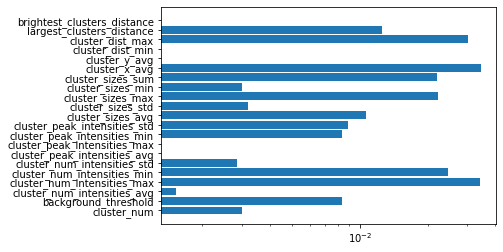

In [33]:
scaler = StandardScaler()
X = real_X.to_numpy()
X = scaler.fit_transform(X)
mi = mutual_info_regression(X, real_y.to_numpy())
plt.barh(list(range(mi.shape[0])), mi, tick_label=real_X.columns.values, log=True)

In [36]:
filtered_real_X = real_X.drop(columns=['brightest_clusters_distance', 'cluster_dist_min', 'cluster_y_avg', 'cluster_peak_intensities_max', 'cluster_peak_intensities_avg', 'cluster_num_intensities_avg'])
train_with_features(filtered_real_X, real_y, 'all', rf=False, svm=False)

Training XGBoost..
Mean: 0.7423486348252979, Std Dev: 0.02126550304682739
